# LCA of Germany's grid expansion


In [3]:
import bw2data as bd

In [4]:
bd.projects.set_current("bw25_ei310_premise2.3.0dev1_new")

We do quite a few calculations here. To save some time, e.g., if only interested in the plots, set the "recalculate" variable to False.


In [5]:
method = ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')

In [6]:
recalculate = False

## GWI of static vs prospective expansion (Figure 4)


In [7]:
static_expansion_nodes = sorted([node for node in bd.Database("grid_expansion_static")])
prospective_expansion_nodes_base = sorted(
    [
        node
        for node in bd.Database("grid_expansion_prospective")
        if "NPi" in node["name"]
    ]
)
prospective_expansion_nodes_PkBudg1000 = sorted(
    [
        node
        for node in bd.Database("grid_expansion_prospective")
        if "PkBudg1000" in node["name"]
    ]
)
prospective_expansion_nodes_PkBudg650 = sorted(
    [
        node
        for node in bd.Database("grid_expansion_prospective")
        if "PkBudg650" in node["name"]
    ]
)
prospective_expansion_nodes = (
    prospective_expansion_nodes_base
    + prospective_expansion_nodes_PkBudg1000
    + prospective_expansion_nodes_PkBudg650
)

Calculating the LCA results for the static and prospective cases:


In [8]:
import bw2calc as bc
import json

if recalculate:
    # static expansion
    results_components = {}
    lca = bc.LCA(demand={static_expansion_nodes[0]: 1}, method=method)
    lca.lci(factorize=True)
    for node in static_expansion_nodes:
        component_results = {}
        for exc in node.technosphere():
            lca.lcia(demand={exc.input.id: exc.amount})
            component_results[exc.input["name"]] = lca.score
        results_components[node["name"]] = component_results

    # prospective expansion
    lca = bc.LCA(demand={prospective_expansion_nodes[0]: 1}, method=method)
    lca.lci(factorize=True)
    for node in prospective_expansion_nodes:
        component_results = {}
        for exc in node.technosphere():
            lca.lcia(demand={exc.input.id: exc.amount})
            component_results[exc.input["name"]] = lca.score
        results_components[node["name"]] = component_results

    json.dump(results_components, open("data/expansion_component_results_rev1.json", "w"))

In [9]:
import pandas as pd

results_components = json.load(open("data/expansion_component_results_rev1.json"))
df_components = pd.DataFrame(results_components)

df_components.columns = pd.MultiIndex.from_tuples(
    [(col.split("_", 2)[1], col.rsplit("_", 1)[1]) for col in df_components.columns]
)

Plotting setup:


In [10]:
from RWTHColors import ColorManager

cm = ColorManager()

plot_colors = []
plot_colors_light = []
color_list = [
    cm.RWTHBlau,
    #   cm.RWTHPetrol,
    cm.RWTHTuerkis,
    cm.RWTHGruen,
    cm.RWTHMaiGruen,
    cm.RWTHOrange,
    cm.RWTHRot,
    # cm.RWTHBordeaux,
    # cm.RWTHViolett,
    cm.RWTHLila,
]
intensities = [100, 50, 10]

for intensity in intensities:
    for color in color_list:
        plot_colors.append(color.p(intensity))

for intensity in [75, 50, 10]:
    for color in color_list:
        plot_colors_light.append(color.p(intensity))

plot_colors_expansion = [
    cm.RWTHBlau.p(100),
    "#2069AB",
    cm.RWTHBlau.p(75),
    cm.RWTHBlau.p(50),
    cm.RWTHBlau.p(25),
]

plot_colors_components = [
    cm.RWTHPetrol.p(100),  # overhead lines
    cm.RWTHGruen.p(100),  # cables
    cm.RWTHMagenta.p(75),  # switchgears
    cm.RWTHLila.p(100),  # transformers
    cm.RWTHViolett.p(100),  # substations
]

plot_colors_materials = [
    cm.RWTHOrange.p(100),  # aluminium
    cm.RWTHTuerkis.p(100),  # iron & steel
    cm.RWTHRot.p(75),  # copper
    cm.RWTHMaiGruen.p(100),  # SF6
    cm.RWTHGelb.p(75),  # plastics
    cm.RWTHPetrol.p(50),  # concrete
    cm.RWTHSchwarz.p(50),  # other materials
]

plot_colors_processes = [
    cm.RWTHGelb.p(100),  # electricity
    cm.RWTHTuerkis.p(50),  # iron & steel (process emissions)
    cm.RWTHRot.p(100),  # heat
    cm.RWTHBlau.p(50),  # transport
    cm.RWTHSchwarz.p(75),  # coal
    cm.RWTHMaiGruen.p(100),  # SF6
    cm.RWTHOrange.p(50),  # aluminium (process emissions)
    cm.RWTHViolett.p(75),  # clinker
    cm.RWTHSchwarz.p(50),  # other processes
]

In [11]:
df_sankey = pd.read_csv("data/sankey_data.csv")
score_grid_status_quo = df_sankey[df_sankey["target"] == "grid status quo"][
    "value"
].sum()
data_base = {"Score": [score_grid_status_quo]}
df_base = pd.DataFrame(data_base)

data_static = {"Score": df_components["static"].sum().values / 1e9}
df_static = pd.DataFrame(data_static)

data_NPi = {"Score": df_components["NPi"].sum().values / 1e9}
df_NPi = pd.DataFrame(data_NPi)

data_PkBudg1000 = {"Score": df_components["PkBudg1000"].sum().values / 1e9}
df_PkBudg1000 = pd.DataFrame(data_PkBudg1000)

data_PkBudg650 = {"Score": df_components["PkBudg650"].sum().values / 1e9}
df_PkBudg650 = pd.DataFrame(data_PkBudg650)


## GWI contributions on the expansion period, component, material and process level (Figure 4)


### Components & Expansion Periods


In [12]:
# Data
df_sankey = pd.read_csv("data/sankey_data.csv")
score_grid_status_quo = df_sankey[df_sankey["target"] == "grid status quo"][
    "value"
].sum()
data_base = {"Score": [score_grid_status_quo]}
df_base = pd.DataFrame(data_base)

data_static = {"Score": df_components["static"].sum().values / 1e9}
df_static = pd.DataFrame(data_static)

data_NPi = {"Score": df_components["NPi"].sum().values / 1e9}
df_NPi = pd.DataFrame(data_NPi)

data_PkBudg1000 = {"Score": df_components["PkBudg1000"].sum().values / 1e9}
df_PkBudg1000 = pd.DataFrame(data_PkBudg1000)

data_PkBudg650 = {"Score": df_components["PkBudg650"].sum().values / 1e9}
df_PkBudg650 = pd.DataFrame(data_PkBudg650)

# Aggregate expansion to 2037 & 2040
for df in [df_static, df_NPi, df_PkBudg1000, df_PkBudg650]:
    df.at[3, "Score"] = df["Score"].iloc[3:5].sum()
    df.drop(index=4, inplace=True)
    
df_expansion_periods = pd.DataFrame({
    "BAU": df_static["Score"].values,
    "3.0°C scenario": df_NPi["Score"].values,
    "2.0°C scenario": df_PkBudg1000["Score"].values,
    "1.5°C scenario": df_PkBudg650["Score"].values,
})

df_expansion_periods.loc["SPACING"] = [
    0,
    df_expansion_periods["BAU"].sum() - df_expansion_periods["3.0°C scenario"].sum(),
    df_expansion_periods["BAU"].sum() - df_expansion_periods["2.0°C scenario"].sum(),
    df_expansion_periods["BAU"].sum() - df_expansion_periods["1.5°C scenario"].sum(),
]

df_expansion_periods.index = ["2023 → 2025", "2025 → 2030", "2030 → 2035", "2035 → 2040", "2040 → 2045", "SPACING"]

In [25]:
df_expansion_periods[df_expansion_periods.index != "SPACING"].sum()

BAU               29.699357
3.0°C scenario    24.961811
2.0°C scenario    23.147487
1.5°C scenario    21.970552
dtype: float64

In [13]:
components = pd.DataFrame(
    {
        "static": df_components["static"].T.sum().values,
        "Base": df_components["NPi"].T.sum().values,
        "PkBudg1000": df_components["PkBudg1000"].T.sum().values,
        "PkBudg650": df_components["PkBudg650"].T.sum().values,
    },
    index=df_components.index,
)

component_groups = {
    "Overhead line": "overhead lines",
    "cable": "cables",
    "Transformer": "transformers",
    "switchgear": "switchgears",
    "Substation": "substations",
}


def map_labels(labels, groups, other_label="other"):
    new_labels = {}
    for label in labels:
        for key, group in groups.items():
            if key in label:
                new_labels[label] = group
                break
        else:
            new_labels[label] = other_label
    return new_labels


components.index = components.index.map(
    map_labels(components.index, component_groups, other_label="other components")
)
components = components.groupby(level=0).sum()

# sorting
components["sort_key"] = components.index != "other components"
components = components.sort_values(by=["sort_key", "static"], ascending=[True, True])
components = components.drop(columns="sort_key")

components.loc["SPACING"] = [
    0,
    components["static"].sum() - components["Base"].sum(),
    components["static"].sum() - components["PkBudg1000"].sum(),
    components["static"].sum() - components["PkBudg650"].sum(),
]
components

,static,Base,PkBudg1000,PkBudg650
substations,4.158338e+08,3.711669e+08,3.468822e+08,3.116656e+08
transformers,1.338557e+09,1.119881e+09,9.870253e+08,8.379386e+08
switchgears,2.489476e+09,2.450506e+09,2.436907e+09,2.428772e+09
cables,1.240264e+10,1.006400e+10,9.174178e+09,8.675103e+09
overhead lines,1.305285e+10,1.095626e+10,1.020249e+10,9.717073e+09
SPACING,0.000000e+00,4.737546e+09,6.551870e+09,7.728805e+09


### Materials


In [14]:
import bw2calc as bc

In [15]:
if recalculate:
    results_materials = {}
    bioflows = {}
    material_sums = {}

    for node in static_expansion_nodes + prospective_expansion_nodes:
        component_results = {}
        lca = bc.LCA({node: 1}, method=method)
        lca.lci(factorize=True)
        for component in node.technosphere():
            material_results = {}
            for material in list(component.input.technosphere()):
                lca.lcia(demand={material.input.id: material.amount * component.amount})
                material_results[material.input["name"]] = lca.score
            for bioflow in component.input.biosphere():
                bioflows[component.input["name"]] = bioflow
            component_results[component.input["name"]] = material_results

        results_materials[node["name"]] = component_results

    # Sum up materials
    for scenario, comp in results_materials.items():
        for component, materials in comp.items():
            for material, value in materials.items():
                if material not in material_sums:
                    material_sums[material] = {}
                if scenario not in material_sums[material]:
                    material_sums[material][scenario] = 0
                material_sums[material][scenario] += value

    with open("data/expansion_materials_results_remind-eu_premise_gwp.json", "w") as f:
        json.dump(material_sums, f)

In [16]:
results_materials = json.load(open("data/expansion_materials_results_remind-eu_premise_gwp.json"))
materials = pd.DataFrame.from_dict(results_materials, orient="index")

In [17]:
# Add SF6 leakage
distributed_components = json.load(open("data/distributed_components.json"))

sf6_row = {}

for col, year in zip(
    materials.columns,
    [
        2023,
        2025,
        2030,
        2035,
        2037,
        2040,
        2023,
        2025,
        2030,
        2035,
        2037,
        2040,
        2023,
        2025,
        2030,
        2035,
        2037,
        2040,
        2023,
        2025,
        2030,
        2035,
        2037,
        2040,
    ],
):
    sf6_impact = (
        distributed_components[str(year)]["gas_insulated_switchgear_420kv"]
        * 28.6
        * 25200
    )  # emissions and CF of sf6
    sf6_row[col] = sf6_impact

materials.loc["sulfur hexafluoride"] = sf6_row

In [18]:
material_groups = {
    "aluminium": "aluminum",
    "copper": "copper",
    "iron": "iron & steel",
    "steel": "iron & steel",
    "concrete": "concrete",
    "cement": "concrete",
    "sulfur hexafluoride": "SF6",
    "polyethylene": "plastics",
    "polypropylene": "plastics",
    "plastic": "plastics",
}

materials.index = materials.index.map(
    map_labels(materials.index, material_groups, other_label="other materials")
)
materials = materials.groupby(level=0).sum()

materials.columns = pd.MultiIndex.from_tuples(
    [(col.split("_", 2)[1], col.rsplit("_", 1)[1]) for col in materials.columns]
)

materials = pd.DataFrame(
    {
        "static": materials["static"].T.sum().values,
        "Base": materials["NPi"].T.sum().values,
        "PkBudg1000": materials["PkBudg1000"].T.sum().values,
        "PkBudg650": materials["PkBudg650"].T.sum().values,
    },
    index=materials.index,
)

# sorting
materials["sort_key"] = materials.index != "other materials"
materials = materials.sort_values(by=["sort_key", "static"], ascending=[True, True])
materials = materials.drop(columns="sort_key")

materials.loc["SPACING"] = [
    0,
    materials["static"].sum() - materials["Base"].sum(),
    materials["static"].sum() - materials["PkBudg1000"].sum(),
    materials["static"].sum() - materials["PkBudg650"].sum(),
]
materials

,static,Base,PkBudg1000,PkBudg650
other materials,1.484672e+09,1.296049e+09,1.134524e+09,9.475900e+08
concrete,1.144983e+09,1.097148e+09,1.056925e+09,1.028788e+09
plastics,1.741568e+09,1.553857e+09,1.476382e+09,1.414076e+09
SF6,2.302957e+09,2.299684e+09,2.298785e+09,2.298400e+09
copper,4.548871e+09,3.870185e+09,3.517111e+09,3.270716e+09
iron & steel,6.190469e+09,5.563720e+09,5.252022e+09,4.825010e+09
aluminum,1.228584e+10,9.281168e+09,8.411738e+09,8.185972e+09
SPACING,0.000000e+00,4.737546e+09,6.551870e+09,7.728805e+09


### Processes


In [19]:
import bw2analyzer as ba

if recalculate:
    process_results = {}
    product_impacts_static = {}
    product_impacts_base = {}
    product_impacts_PkBudg1000 = {}
    product_impacts_PkBudg650 = {}

    lca = bc.LCA(
        {static_expansion_nodes[0]: 1}, method=method
    )  # just to build the matrices
    lca.lci(factorize=True)
    for node in static_expansion_nodes:
        lca.lcia(demand={node.id: 1})
        top_processes = ba.ContributionAnalysis().annotated_top_processes(
            lca, limit=1000
        )
        for process in top_processes:
            if process[2]["reference product"] in product_impacts_static:
                product_impacts_static[process[2]["reference product"]] += process[0]
            else:
                product_impacts_static[process[2]["reference product"]] = process[0]
    process_results["static"] = product_impacts_static

    for node in prospective_expansion_nodes_base:
        lca = bc.LCA({node: 1}, method=method)
        lca.lci()
        lca.lcia()
        top_processes = ba.ContributionAnalysis().annotated_top_processes(
            lca, limit=1000
        )
        for process in top_processes:
            if process[2]["reference product"] in product_impacts_base:
                product_impacts_base[process[2]["reference product"]] += process[0]
            else:
                product_impacts_base[process[2]["reference product"]] = process[0]
    process_results["Base"] = product_impacts_base

    for node in prospective_expansion_nodes_PkBudg1000:
        lca = bc.LCA({node: 1}, method=method)
        lca.lci()
        lca.lcia()
        top_processes = ba.ContributionAnalysis().annotated_top_processes(
            lca, limit=1000
        )
        for process in top_processes:
            if process[2]["reference product"] in product_impacts_PkBudg1000:
                product_impacts_PkBudg1000[process[2]["reference product"]] += process[0]
            else:
                product_impacts_PkBudg1000[process[2]["reference product"]] = process[0]
    process_results["PkBudg1000"] = product_impacts_PkBudg1000

    for node in prospective_expansion_nodes_PkBudg650:
        lca = bc.LCA({node: 1}, method=method)
        lca.lci()
        lca.lcia()
        top_processes = ba.ContributionAnalysis().annotated_top_processes(
            lca, limit=1000
        )
        for process in top_processes:
            if process[2]["reference product"] in product_impacts_PkBudg650:
                product_impacts_PkBudg650[process[2]["reference product"]] += process[0]
            else:
                product_impacts_PkBudg650[process[2]["reference product"]] = process[0]
    process_results["PkBudg650"] = product_impacts_PkBudg650

    with open("data/expansion_process_results_remind-eu_premise_gwp.json", "w") as f:
        json.dump(process_results, f)

In [20]:
import json
import pandas as pd
process_results = json.load(open("data/expansion_process_results_remind-eu_premise_gwp.json"))
processes = pd.DataFrame(process_results)

product_groups = {
    "electricity": "electricity",
    "heat": "heat",
    "transport": "transport",
    "aluminium": "aluminum (process emissions)",
    "iron": "iron & steel (process emissions)",
    "steel": "iron & steel (process emissions)",
    "coal": "coal",
    "coke": "coal",
    "clinker": "clinker",
    "diesel": "transport",
    "Gas insulated switchgear": "SF6",
    "sulfur hexafluoride": "SF6",
}

processes.index = processes.index.map(
    map_labels(processes.index, product_groups, other_label="other processes")
)

processes = processes.groupby(level=0).sum()

# sorting
processes["sort_key"] = processes.index != "other processes"
processes = processes.sort_values(by=["sort_key", "static"], ascending=[True, True])
processes = processes.drop(columns="sort_key")

processes.loc["SPACING"] = [
    0,
    processes["static"].sum() - processes["Base"].sum(),
    processes["static"].sum() - processes["PkBudg1000"].sum(),
    processes["static"].sum() - processes["PkBudg650"].sum(),
]
processes

,static,Base,PkBudg1000,PkBudg650
other processes,2.810049e+09,2.873366e+09,2.750287e+09,2.430700e+09
clinker,1.065846e+09,1.102981e+09,1.069965e+09,1.064379e+09
aluminum (process emissions),1.795167e+09,1.667209e+09,1.613818e+09,1.636309e+09
SF6,2.295456e+09,2.295426e+09,2.295416e+09,2.295443e+09
coal,2.449842e+09,1.919877e+09,1.752407e+09,1.615522e+09
transport,2.703623e+09,2.460013e+09,2.366278e+09,2.283301e+09
heat,3.091010e+09,2.970820e+09,2.734778e+09,2.591355e+09
iron & steel (process emissions),3.426043e+09,3.150804e+09,3.013207e+09,2.803604e+09
electricity,9.858210e+09,6.363690e+09,5.402472e+09,5.093335e+09
SPACING,0.000000e+00,4.691059e+09,6.496617e+09,7.681297e+09


### Plotting


In [40]:
import numpy as np
def round_to_percentages(df):
    def adjust_to_100(absolute_values):
        total = absolute_values.sum()
        percentages = (absolute_values / total * 100).round()
        difference = 100 - percentages.sum()
        if difference != 0:
            idx = absolute_values.index[
                absolute_values.index.str.contains("other")
            ].tolist()
            if not idx:  # If no "other" index, use the largest decimal part
                # Assign the difference to the index with the highest fractional part
                fractions = (absolute_values / total * 100) % 1
                idx = fractions.idxmax()
            else:
                idx = idx[0]
            percentages.at[idx] += difference

        return percentages

    rounded_df = df.apply(adjust_to_100, axis=0).astype(int)
    assert (
        rounded_df.sum() == np.array([100, 100, 100, 100])
    ).all()  # check rounding errors
    return rounded_df

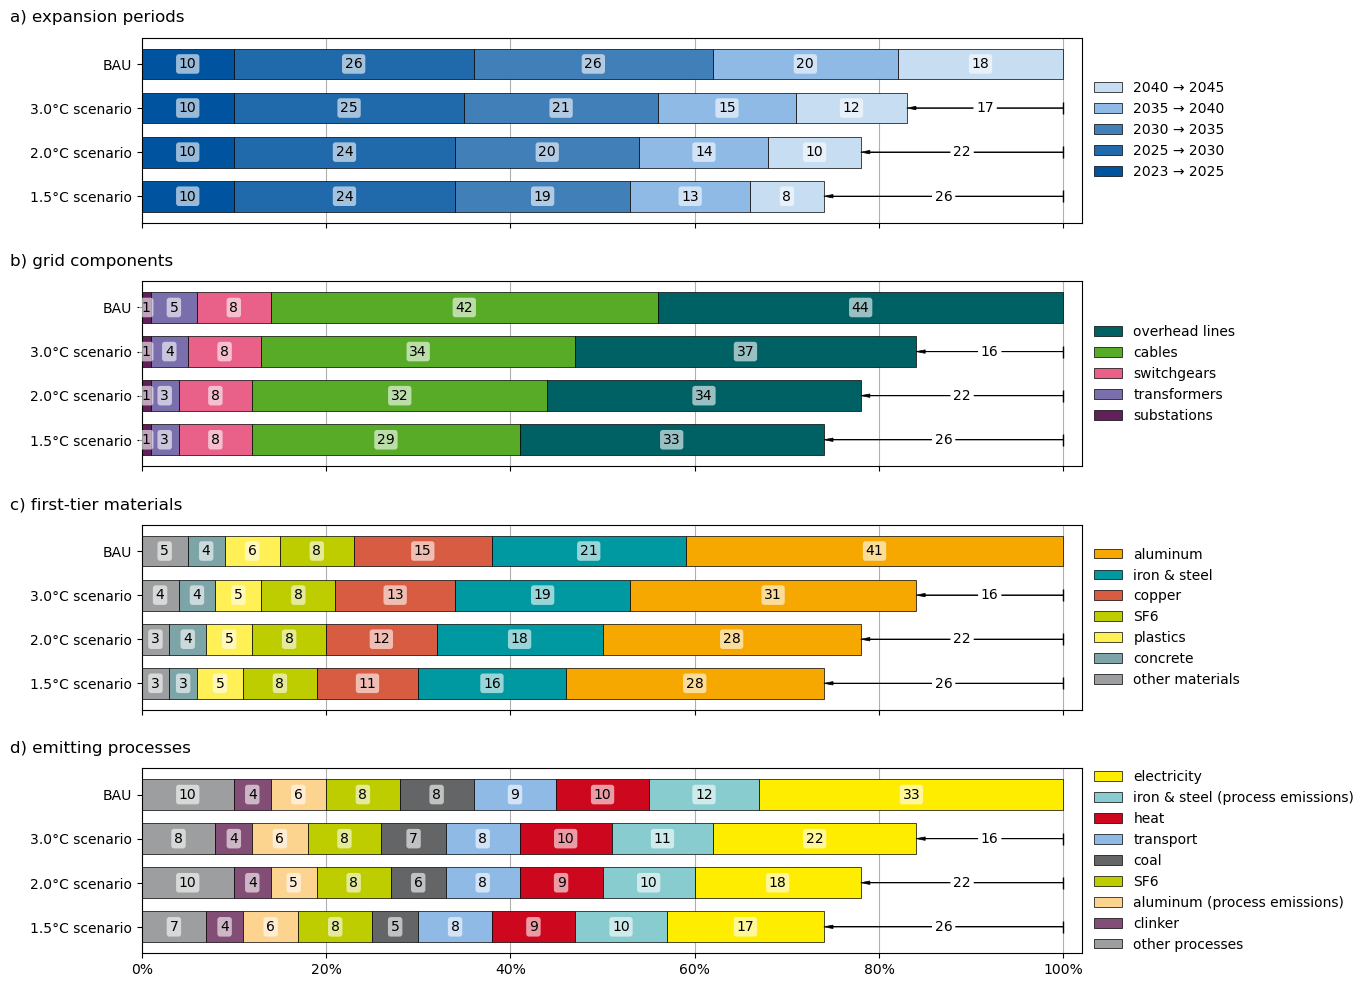

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.use("rwth")

expansion_plot = round_to_percentages(df_expansion_periods)
components_plot = round_to_percentages(components)
materials_plot = round_to_percentages(materials)
processes_plot = round_to_percentages(processes)

scenario_label_mapping = {
    "static": "BAU",
    "Base": "3.0°C scenario",
    "PkBudg1000": "2.0°C scenario",
    "PkBudg650": "1.5°C scenario",
}
for df in [expansion_plot, components_plot, materials_plot, processes_plot]:
    df.columns = df.columns.map(lambda x: scenario_label_mapping.get(x, x))


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)
plt.subplots_adjust(hspace=0.6)

general_plot_kwargs = dict(
    kind="barh",
    stacked=True,
    width=0.7,
    edgecolor="black",
    linewidth=0.5,
)

expansion_colors = plot_colors_expansion + ["none"]
expansion_plot.T.plot(ax=axes[0], color=expansion_colors, **general_plot_kwargs)

component_colors = ["none"] + plot_colors_components
components_plot.T.plot(ax=axes[1], color=component_colors[::-1], **general_plot_kwargs)

material_colors = ["none"] + plot_colors_materials
materials_plot.T.plot(ax=axes[2], color=material_colors[::-1], **general_plot_kwargs)

process_colors = ["none"] + plot_colors_processes
processes_plot.T.plot(ax=axes[3], color=process_colors[::-1], **general_plot_kwargs)

for idx, (ax, data) in enumerate(
    zip(axes, [expansion_plot, components_plot, materials_plot, processes_plot])
):
    ax.invert_yaxis()
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*[(h, l) for h, l in zip(handles, labels) if l != "SPACING"])
    ax.legend(
        handles[::-1],
        labels[::-1],
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=False,
    )

    ax.xaxis.grid(True)
    ax.set_axisbelow(True)

    totals = data.sum(axis=1)

    # Adding percentage labels to each bar
    for bar in ax.patches:
        label_x_pos = bar.get_x() + bar.get_width() / 2 
        label_y_pos = bar.get_y() + bar.get_height() / 2
        total_width = sum(
            [p.get_width() for p in ax.patches if p.get_y() == bar.get_y()]
        )  # Sum width of all bars in this row
        percentage = bar.get_width()
        percentage_text = f"{round(percentage)}"
        if percentage > 0:
            rotation = 0
            fontsize = 10
            bbox_props = dict(
                boxstyle="round,pad=0.2", ec="none", fc="white", alpha=0.6
            )
            if bar in ax.patches[-4:]:
                bbox_props = dict(
                    boxstyle="round,pad=0.2", ec="none", fc="white", alpha=1
                )
                if percentage < 5:
                    label_x_pos = label_x_pos + 0.5

            ax.text(
                label_x_pos,
                label_y_pos,
                percentage_text,
                ha="center",
                va="center",
                rotation=rotation,
                fontsize=fontsize,
                bbox=bbox_props,
            )

    # arrows from right end of bars
    for bar in ax.patches[-3:]:
        bar.set_edgecolor("none")

        x_end = bar.get_x() + bar.get_width() 
        y_position = (
            bar.get_y() + bar.get_height() / 2
        )

        head_width = bar.get_height() / 9
        head_length = 1
        ax.arrow(
            x_end,
            y_position,
            -bar.get_width() + head_length,
            0,
            head_width=head_width,
            head_length=head_length,
            width=0.01,
            fc="black",
            ec="black",
            lw=0.5,
        )
        ax.plot(x_end, y_position, marker="|", color="black", markersize=8)

axes[-1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}%"))

for ax in axes:
    ax.set_xlim(0, 102)

subplot_labels = ["a) expansion periods", "b) grid components", "c) first-tier materials", "d) emitting processes"]
for i, ax in enumerate(axes):
    ax.text(-0.14, 1.15, subplot_labels[i], transform=ax.transAxes,
    # ax.text(-0.1175, 1.15, subplot_labels[i], transform=ax.transAxes,
            fontsize=12, va='top', ha='left')

plt.subplots_adjust(hspace=0.8)

plt.tight_layout(h_pad=0.5)

plt.savefig("figs/Fig4.svg", format="svg", bbox_inches="tight")
plt.show()

## Burden Shifting (Figure 5)

In [42]:
if recalculate:
    functional_units = {
        "static": {act.id: 1 for act in static_expansion_nodes},
        "Base": {act.id: 1 for act in prospective_expansion_nodes_base},
        "PkBudg1000": {act.id: 1 for act in prospective_expansion_nodes_PkBudg1000},
        "PkBudg650": {act.id: 1 for act in prospective_expansion_nodes_PkBudg650},
    }

    chosen_methods = [m for m in bd.methods if "EF v3.1 no LT" in m[1]]

    mlca_config = {
        "impact_categories": chosen_methods,
    }

    data_objs = bd.get_multilca_data_objs(
        functional_units=functional_units, method_config=mlca_config
    )

    mlca = bc.MultiLCA(
        demands=functional_units, method_config=mlca_config, data_objs=data_objs
    )
    mlca.lci()
    mlca.lcia()

    df = pd.DataFrame(mlca.scores.items(), columns=["MethodProcess", "Score"])
    df[["Method", "Process"]] = pd.DataFrame(
        df["MethodProcess"].tolist(), index=df.index
    )

    df_mlca = df.pivot(index="Process", columns="Method", values="Score")

    def extract_ia_name(method_tuple):
        return method_tuple[2][:-6]  # remove "no LT" from the method name

    df_mlca.columns = df_mlca.columns.map(extract_ia_name)

    json.dump(df_mlca.to_dict(), open("data/expansion_all_impact_categories.json", "w"))

In [43]:
import pandas as pd
import json

In [44]:
df_mlca = pd.DataFrame(json.load(open("data/expansion_all_impact_categories.json")))

df_mlca = df_mlca[
    [
        "acidification",
        "climate change",
        "ecotoxicity: freshwater",
        "energy resources: non-renewable",
        "eutrophication: freshwater",
        "eutrophication: marine",
        "eutrophication: terrestrial",
        "human toxicity: carcinogenic",
        "human toxicity: non-carcinogenic",
        "ionising radiation: human health",
        "land use",
        "material resources: metals/minerals",
        "ozone depletion",
        "particulate matter formation",
        "photochemical oxidant formation: human health",
        "water use",
    ]
]

Normalize with respect to the static results:


In [45]:
df_mlca.loc["Base"] = df_mlca.loc["Base"] / df_mlca.loc["static"]
df_mlca.loc["PkBudg1000"] = df_mlca.loc["PkBudg1000"] / df_mlca.loc["static"]
df_mlca.loc["PkBudg650"] = df_mlca.loc["PkBudg650"] / df_mlca.loc["static"]
df_mlca.loc["static"] = 1

Plot:

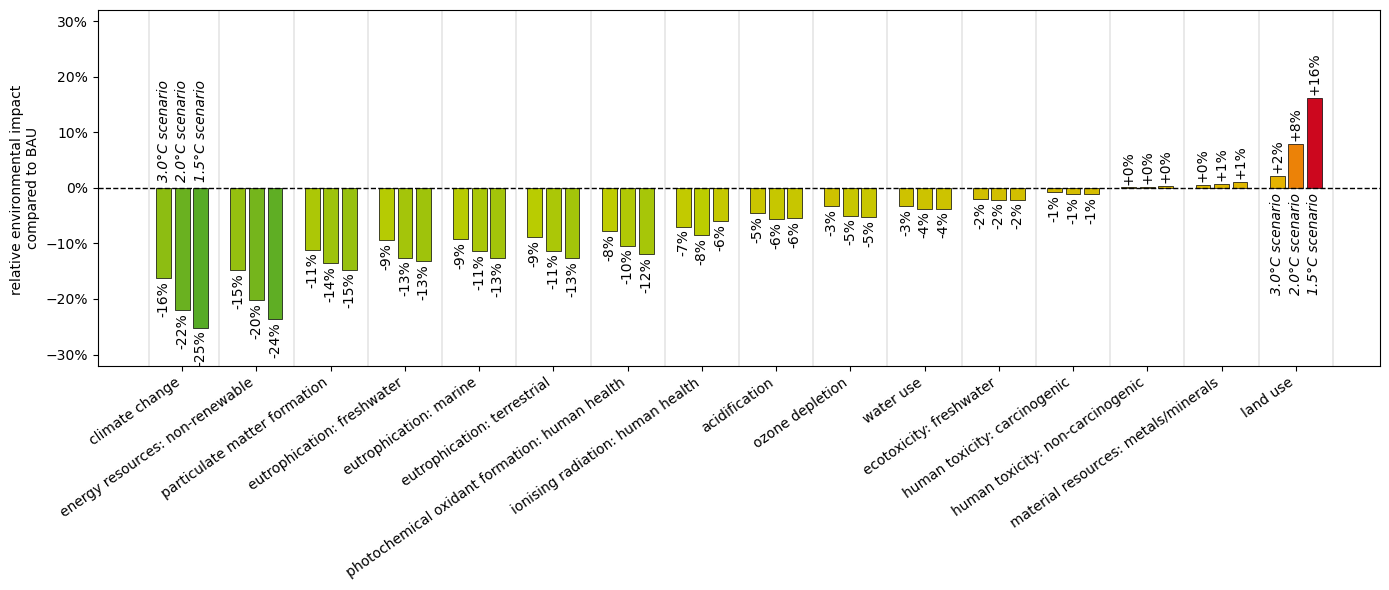

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import PercentFormatter

# Assume df_mlca and cm are already defined

values_base = df_mlca.loc["Base"].sort_values(ascending=True)
values_r26 = df_mlca.loc["PkBudg1000"].sort_values(ascending=True)
values_r19 = df_mlca.loc["PkBudg650"].sort_values(ascending=True)

bordeaux = cm.RWTHBordeaux.p(100)
red = cm.RWTHRot.p(100)
orange = cm.RWTHOrange.p(100)
yellow = cm.RWTHGelb.p(100)
maigreen = cm.RWTHMaiGruen.p(100)
green = cm.RWTHGruen.p(100)

cmap = LinearSegmentedColormap.from_list(
    "custom_red_green", [green, maigreen, orange, red]
)

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        x, y = [vmin, midpoint, vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(result, x, y))

shifted_base = values_base - 1
shifted_r26 = values_r26 - 1
shifted_r19 = values_r19 - 1

all_values = np.concatenate([shifted_r26, shifted_r19, shifted_base])
norm = MidpointNormalize(vmin=all_values.min(), vmax=all_values.max(), midpoint=0)

fig, ax = plt.subplots(figsize=(14, 6))
index = np.arange(len(values_r26)) * 2.5
bar_height = 0.5

bars_base = ax.bar(
    index,
    shifted_base,
    bar_height,
    color=cmap(norm(shifted_base.values)),
    edgecolor="black",
    linewidth=0.5,
)
bars_r19 = ax.bar(
    index + 2.5 * bar_height,
    shifted_r19,
    bar_height,
    color=cmap(norm(shifted_r19.values)),
    edgecolor="black",
    linewidth=0.5,
)
bars_r26 = ax.bar(
    index + 1.25 * bar_height,
    shifted_r26,
    bar_height,
    color=cmap(norm(shifted_r26.values)),
    edgecolor="black",
    linewidth=0.5,
)

ax.set_ylabel("relative environmental impact \ncompared to BAU")
ax.set_ylim(-0.32, 0.32)
ax.axhline(y=0, color="black", linestyle="--", linewidth=1)
ax.set_xticks(index + 1.25 * bar_height)
ax.set_xticklabels(labels=values_r26.index, rotation=35, ha="right")

datasets = [shifted_r26, shifted_r19, shifted_base]
bar_positions = [index + 1.25 * bar_height, index + 2.5 * bar_height, index]

for dataset, bars, position, scenario_label in zip(
    datasets,
    [bars_r26, bars_r19, bars_base],
    bar_positions,
    ["2.0°C scenario", "1.5°C scenario", "3.0°C scenario"],
):
    for idx, height in enumerate(dataset):
        percentage_change = height * 100
        sign = "+" if percentage_change > 0 else ""
        text = f"{sign}{percentage_change:.0f}%"
        ax.text(
            position[idx],
            height + 0.005 if height > 0 else height - 0.005,
            text,
            ha="center",
            va="bottom" if height > 0 else "top",
            rotation=90,
        )
        if idx == 0 or idx == len(dataset) - 1:
            ax.text(
                position[idx],
                -0.01 if height > 0 else 0.01,
                scenario_label,
                ha="center",
                va="top" if height > 0 else "bottom",
                rotation=90,
                style="italic",
            )

ax.axvline(x=-0.5, color="grey", linestyle="-", linewidth=0.25)
for x_pos in index + 3.75 * bar_height:
    ax.axvline(x=x_pos, color="grey", linestyle="-", linewidth=0.25)

ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.tight_layout()
plt.savefig("figs/Fig5.svg", format="svg", bbox_inches="tight")
plt.show()

## SI: Sensitivities

### AL / CU ratios

In [ ]:
import bw2data as bd

hv_cable_al = "land_cable_vpe_al_50kv"
hv_cable_cu = "land_cable_oil_cu_150kv"
mv_cable_al = "land_cable_vpe_al_10kv"
mv_cable_cu = "land_cable_epr_cu_11kv"
lv_cable_al = "land_cable_vpe_al_04kv"
lv_cable_cu = "land_cable_vpe_cu_1kv"

hv_cables = [hv_cable_al, hv_cable_cu]
mv_cables = [mv_cable_al, mv_cable_cu]
lv_cables = [lv_cable_al, lv_cable_cu]

results = {}

# Map voltage levels to your variable names for easier lookup
cable_map = {
    "HV": {"al_code": hv_cable_al, "all_codes": hv_cables},
    "MV": {"al_code": mv_cable_al, "all_codes": mv_cables},
    "LV": {"al_code": lv_cable_al, "all_codes": lv_cables}
}

for scenario, scenario_name in [(prospective_expansion_nodes_base, "Base"), (prospective_expansion_nodes_PkBudg1000, "PkBudg1000"), (prospective_expansion_nodes_PkBudg650, "PkBudg650")]:
    grid_ids_and_shares = {}
    
    for grid_node in scenario:
        # Initialize node entry if not exists
        grid_ids_and_shares[grid_node.id] = {}
        
        # First pass: Collect what is already there
        for exc in grid_node.technosphere():
            for level, config in cable_map.items():
                if exc.input["code"] in config["all_codes"]:
                    # Ensure level dictionary exists (e.g., grid_ids_and_shares[id]["HV"])
                    grid_ids_and_shares[grid_node.id].setdefault(level, {})
                    
                    metal = "AL" if exc.input["code"] == config["al_code"] else "CU"
                    grid_ids_and_shares[grid_node.id][level][metal] = {exc.input.id: exc.amount}

        # Second pass: "Inject" missing AL/CU placeholders so the sensitivity study has indices to target
        for level, config in cable_map.items():
            if level in grid_ids_and_shares[grid_node.id]:
                level_data = grid_ids_and_shares[grid_node.id][level]
                
                # If one metal is present but the other isn't, find the missing one in the same DB
                for current_metal, target_metal, target_code in [("CU", "AL", config["al_code"]), ("AL", "CU", "placeholder")]:
                    # We mainly care about adding AL if only CU exists
                    if current_metal in level_data and target_metal not in level_data:
                        # Get the database name from the existing metal exchange
                        existing_id = list(level_data[current_metal].keys())[0]
                        db_name = bd.get_activity(existing_id)["database"]
                        
                        try:
                            # Find the corresponding cable in the SAME database
                            missing_act = bd.get_activity((db_name, target_code))
                            level_data[target_metal] = {missing_act.id: 0.0}
                        except bd.errors.UnknownObject:
                            # Fallback if the other metal doesn't exist in that specific database
                            continue
                        
    import numpy as np
    import bw_processing as bwp

    sensitivity_shares = np.linspace(0, 1, 11)

    # Generate scenario names
    scenario_names = ["Baseline"] + [f"Al_Share_{int(s*100)}pct" for s in sensitivity_shares]

    # Reference baseline shares (from your existing study)
    BASE_SHARES = {
        "HV": 0.5,
        "MV": 0.75,
        "LV": 0.7
    }

    indices = []
    data_rows = []

    for grid_id, levels in grid_ids_and_shares.items():
        for level, metals in levels.items():
            # Identify IDs and current values
            al_info = metals.get("AL", {})
            cu_info = metals.get("CU", {})
            
            al_id = list(al_info.keys())[0] if al_info else None
            cu_id = list(cu_info.keys())[0] if cu_info else None
            
            # Calculate total length (Al + Cu) to keep it constant
            total_len = sum(al_info.values()) + sum(cu_info.values())
            
            # --- Scenario Calculation ---
            al_scenario_values = []
            cu_scenario_values = []
            
            # 1. First entry: Baseline
            base_al_share = BASE_SHARES[level]
            al_scenario_values.append(total_len * base_al_share)
            cu_scenario_values.append(total_len * (1 - base_al_share))
            
            # 2. Subsequent entries: 0% to 100% steps
            for share in sensitivity_shares:
                al_scenario_values.append(total_len * share)
                cu_scenario_values.append(total_len * (1 - share))
                
            # Append to the datapackage arrays
            if al_id:
                indices.append((al_id, grid_id))
                data_rows.append(al_scenario_values)
            if cu_id:
                indices.append((cu_id, grid_id))
                data_rows.append(cu_scenario_values)

    # Convert to final arrays
    indices_array = np.array(indices, dtype=bwp.INDICES_DTYPE)
    data_array = np.array(data_rows)
    flip_array = np.ones(len(indices), dtype=bool)

    dp = bwp.create_datapackage(name="absolute-share-sensitivity", sequential=True)

    dp.add_persistent_array(
        matrix="technosphere_matrix",
        indices_array=indices_array,
        data_array=data_array,
        flip_array=flip_array,
    )

    fu, datapackages, _ = bd.prepare_lca_inputs({grid_node: 1 for grid_node in scenario}, method=method)
    datapackages.append(dp)

    import bw2calc as bc

    lca = bc.LCA(
        demand=fu,
        method=method,
        data_objs=datapackages,
        use_arrays=True,
    )
    lca.lci()
    lca.lcia()

    import pandas as pd

    lca.keep_first_iteration() # keep the base values

    results_list = []

    for _, label in zip(lca, scenario_names):
        results_list.append((label, lca.score))
        print(scenario_name, label, lca.score)

    results[scenario_name] = results_list


/Users/timodiepers/anaconda3/envs/paper-plca-grid-expansion/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.80e+13)
  warnings.warn(msg, UmfpackWarning)


PkBudg1000 Baseline 22961545193.67415
PkBudg1000 Al_Share_0pct 22440140170.832764
PkBudg1000 Al_Share_10pct 22520846320.98275
PkBudg1000 Al_Share_20pct 22601552471.132706
PkBudg1000 Al_Share_30pct 22682258621.282753
PkBudg1000 Al_Share_40pct 22762964771.43265
PkBudg1000 Al_Share_50pct 22843670921.582684
PkBudg1000 Al_Share_60pct 22924377071.73263
PkBudg1000 Al_Share_70pct 23005083221.882576
PkBudg1000 Al_Share_80pct 23085789372.032608
PkBudg1000 Al_Share_90pct 23166495522.182568
PkBudg1000 Al_Share_100pct 23247201672.332535
PkBudg650 Baseline 21805206388.093987
PkBudg650 Al_Share_0pct 21133716951.432354
PkBudg650 Al_Share_10pct 21234858831.71038
PkBudg650 Al_Share_20pct 21336000711.988377
PkBudg650 Al_Share_30pct 21437142592.26629
PkBudg650 Al_Share_40pct 21538284472.54438
PkBudg650 Al_Share_50pct 21639426352.822384
PkBudg650 Al_Share_60pct 21740568233.10035
PkBudg650 Al_Share_70pct 21841710113.37832
PkBudg650 Al_Share_80pct 21942851993.656387
PkBudg650 Al_Share_90pct 22043993873.93441

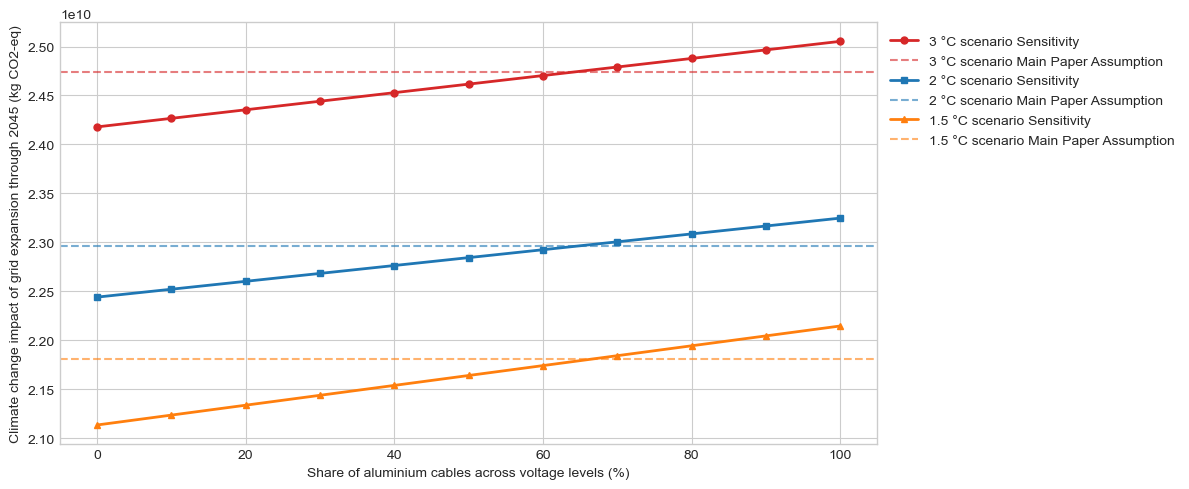

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 1. Create the DataFrame
# (Using a dictionary for clarity, but you can also load your csv here)
data = {
    'Scenario': ['Default']*12 + ['PkBudg1000']*12 + ['PkBudg650']*12,
    'Share': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None] * 3,
    'Type': (['Variation']*11 + ['Baseline']) * 3,
    'Value': [
        # Default
        24179211492.94, 24266610307.96, 24354009122.98, 24441407938.00, 24528806753.02, 
        24616205568.04, 24703604383.06, 24791003198.08, 24878402013.11, 24965800828.13, 
        25053199643.15, 24740376488.57,
        # PkBudg1000
        22440140170.83, 22520846320.98, 22601552471.13, 22682258621.28, 22762964771.43, 
        22843670921.58, 22924377071.73, 23005083221.88, 23085789372.03, 23166495522.18, 
        23247201672.33, 22961545193.67,
        # PkBudg650
        21133716951.43, 21234858831.71, 21336000711.99, 21437142592.27, 21538284472.54, 
        21639426352.82, 21740568233.10, 21841710113.38, 21942851993.66, 22043993873.93, 
        22145135754.21, 21805206388.09
    ]
}

df = pd.DataFrame(data)

# 2. Setup the Plot
plt.figure(figsize=(12, 5))

# Define styling per scenario
scenarios = {
    'Default': {'name': '3 °C scenario', 'color': '#d62728', 'marker': 'o'},
    'PkBudg1000': {'name': '2 °C scenario', 'color': '#1f77b4', 'marker': 's'},
    'PkBudg650': {'name': '1.5 °C scenario', 'color': '#ff7f0e', 'marker': '^'}
}

# 3. Plotting loop
for sc, style in scenarios.items():
    # Filter variation data (the line)
    subset = df[(df['Scenario'] == sc) & (df['Type'] == 'Variation')].sort_values('Share')
    # Filter baseline (the horizontal line)
    baseline_val = df[(df['Scenario'] == sc) & (df['Type'] == 'Baseline')]['Value'].values[0]
    
    # Plot sensitivity line
    plt.plot(subset['Share'], subset['Value'], 
             label=f"{style['name']} Sensitivity", 
             color=style['color'], 
             marker=style['marker'], 
             markersize=5, 
             linewidth=2)
    
    # Plot baseline reference line
    plt.axhline(y=baseline_val, 
                color=style['color'], 
                linestyle='--', 
                alpha=0.6, 
                label=f"{style['name']} Main Paper Assumption")

# 4. Final Formatting
plt.xlabel('Share of aluminium cables across voltage levels (%)')
plt.ylabel('Climate change impact of grid expansion through 2045 (kg CO2-eq)')

# Place legend outside of the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### Cable vs overhead line ratio

In [124]:
import bw2data as bd
import numpy as np
import bw_processing as bwp
import bw2calc as bc

# Define overhead line and cable codes for each voltage level
# EHV DC
ehv_dc_overhead = "overhead_line_HVDC"
ehv_dc_cable = "land_cable_oil_cu_HVDC"

# HV (cables split by AL/CU, so we need both)
hv_overhead = "overhead_line_150kv"
hv_cable_al = "land_cable_vpe_al_50kv"
hv_cable_cu = "land_cable_oil_cu_150kv"

# MV
mv_overhead = "overhead_line_10kv"
mv_cable_al = "land_cable_vpe_al_10kv"
mv_cable_cu = "land_cable_epr_cu_11kv"

# LV
lv_overhead = "overhead_line_04kv"
lv_cable_al = "land_cable_vpe_al_04kv"
lv_cable_cu = "land_cable_vpe_cu_1kv"

# Map voltage levels to component codes
line_map = {
    "EHV_DC": {"overhead_code": ehv_dc_overhead, "cable_codes": [ehv_dc_cable]},
    "HV": {"overhead_code": hv_overhead, "cable_codes": [hv_cable_al, hv_cable_cu]},
    "MV": {"overhead_code": mv_overhead, "cable_codes": [mv_cable_al, mv_cable_cu]},
    "LV": {"overhead_code": lv_overhead, "cable_codes": [lv_cable_al, lv_cable_cu]},
}

# Baseline cable shares (1 - overhead share)
BASE_CABLE_SHARES = {
    "EHV_DC": 1 - 0.05,   # 95% cable
    "HV": 1 - 0.9474,     # 5.26% cable
    "MV": 1 - 0.1847,     # 81.53% cable
    "LV": 1 - 0.0652,     # 93.48% cable
}

results_cable_share = {}
sensitivity_shares = np.linspace(0, 1, 11)
voltage_levels = list(line_map.keys())

for scenario, scenario_name in [
    (prospective_expansion_nodes_base, "Base"),
    (prospective_expansion_nodes_PkBudg1000, "PkBudg1000"),
    (prospective_expansion_nodes_PkBudg650, "PkBudg650")
]:
    print(f"\n--- Processing Scenario: {scenario_name} ---")
    
    # 1. Collect Data & Totals
    grid_ids_and_shares = {}
    for grid_node in scenario:
        grid_ids_and_shares[grid_node.id] = {}
        for exc in grid_node.technosphere():
            for level, config in line_map.items():
                if exc.input["code"] == config["overhead_code"]:
                    grid_ids_and_shares[grid_node.id].setdefault(level, {"overhead": {}, "cables": {}})
                    grid_ids_and_shares[grid_node.id][level]["overhead"][exc.input.id] = exc.amount
                if exc.input["code"] in config["cable_codes"]:
                    grid_ids_and_shares[grid_node.id].setdefault(level, {"overhead": {}, "cables": {}})
                    grid_ids_and_shares[grid_node.id][level]["cables"][exc.input.id] = exc.amount

    # 2. Define Scenario Labels
    # Order: [Baseline, EHV_0, ..., EHV_100, HV_0, ..., HV_100, etc.]
    scenario_labels = ["Baseline"]
    for level in voltage_levels:
        for s in sensitivity_shares:
            scenario_labels.append(f"{level}_{int(s*100)}pct")
    
    num_columns = len(scenario_labels)
    indices = []
    data_matrix = []

    print(f"Building data matrix for {num_columns} sensitivity steps...")

    # 3. Build the Data Matrix
    for grid_id, levels in grid_ids_and_shares.items():
        for level_name, components in levels.items():
            overhead_dict = components.get("overhead", {})
            cable_dict = components.get("cables", {})
            
            # Identify IDs (handles multiple cables per level like AL/CU)
            o_id = list(overhead_dict.keys())[0] if overhead_dict else None
            c_ids = list(cable_dict.keys())
            
            total_len = sum(overhead_dict.values()) + sum(cable_dict.values())
            if total_len == 0: continue

            # Cable mix (how much AL vs CU within the cable share)
            total_c = sum(cable_dict.values())
            c_props = {cid: (amt/total_c if total_c > 0 else 1.0/len(c_ids)) for cid, amt in cable_dict.items()}

            # Create the rows for this specific component set
            # Initialize with 0s, then fill
            o_row = np.zeros(num_columns)
            c_rows = {cid: np.zeros(num_columns) for cid in c_ids}

            for col_idx, label in enumerate(scenario_labels):
                if label == "Baseline":
                    share = BASE_CABLE_SHARES[level_name]
                else:
                    active_level = label.split('_')[0] if "EHV" not in label else "EHV_DC"
                    active_share = int(label.split('_')[-1].replace('pct', '')) / 100.0
                    
                    # If THIS component belongs to the level being varied
                    if level_name == active_level:
                        share = active_share
                    else:
                        # Keep at baseline!
                        share = BASE_CABLE_SHARES[level_name]

                o_row[col_idx] = total_len * (1 - share)
                for cid in c_ids:
                    c_rows[cid][col_idx] = total_len * share * c_props[cid]

            # Add to master lists
            if o_id:
                indices.append((o_id, grid_id))
                data_matrix.append(o_row)
            for cid in c_ids:
                indices.append((cid, grid_id))
                data_matrix.append(c_rows[cid])

    # 4. Run LCA
    print(f"Calculating LCA for {scenario_name}...")
    dp = bwp.create_datapackage(name="isolated-sensitivity", sequential=True)
    dp.add_persistent_array(
        matrix="technosphere_matrix",
        indices_array=np.array(indices, dtype=bwp.INDICES_DTYPE),
        data_array=np.array(data_matrix),
        flip_array=np.ones(len(indices), dtype=bool),
    )

    fu, datapackages, _ = bd.prepare_lca_inputs({grid_node: 1 for grid_node in scenario}, method=method)
    datapackages.append(dp)

    lca = bc.LCA(demand=fu, method=method, data_objs=datapackages, use_arrays=True)
    lca.lci()
    lca.lcia()

    results_list = []
    for label in scenario_labels:
        results_list.append((label, lca.score))
        try:
            next(lca)
        except StopIteration:
            break
            
    results_cable_share[scenario_name] = results_list
    print(f"Finished {scenario_name}. Baseline: {results_list[0][1]:.2e}")

print("\nAll scenarios complete.")


--- Processing Scenario: Base ---
Building data matrix for 45 sensitivity steps...
Calculating LCA for Base...


/Users/timodiepers/anaconda3/envs/paper-plca-grid-expansion/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.80e+13)
  warnings.warn(msg, UmfpackWarning)


Finished Base. Baseline: 2.50e+10

--- Processing Scenario: PkBudg1000 ---
Building data matrix for 45 sensitivity steps...
Calculating LCA for PkBudg1000...
Finished PkBudg1000. Baseline: 2.31e+10

--- Processing Scenario: PkBudg650 ---
Building data matrix for 45 sensitivity steps...
Calculating LCA for PkBudg650...
Finished PkBudg650. Baseline: 2.20e+10

All scenarios complete.


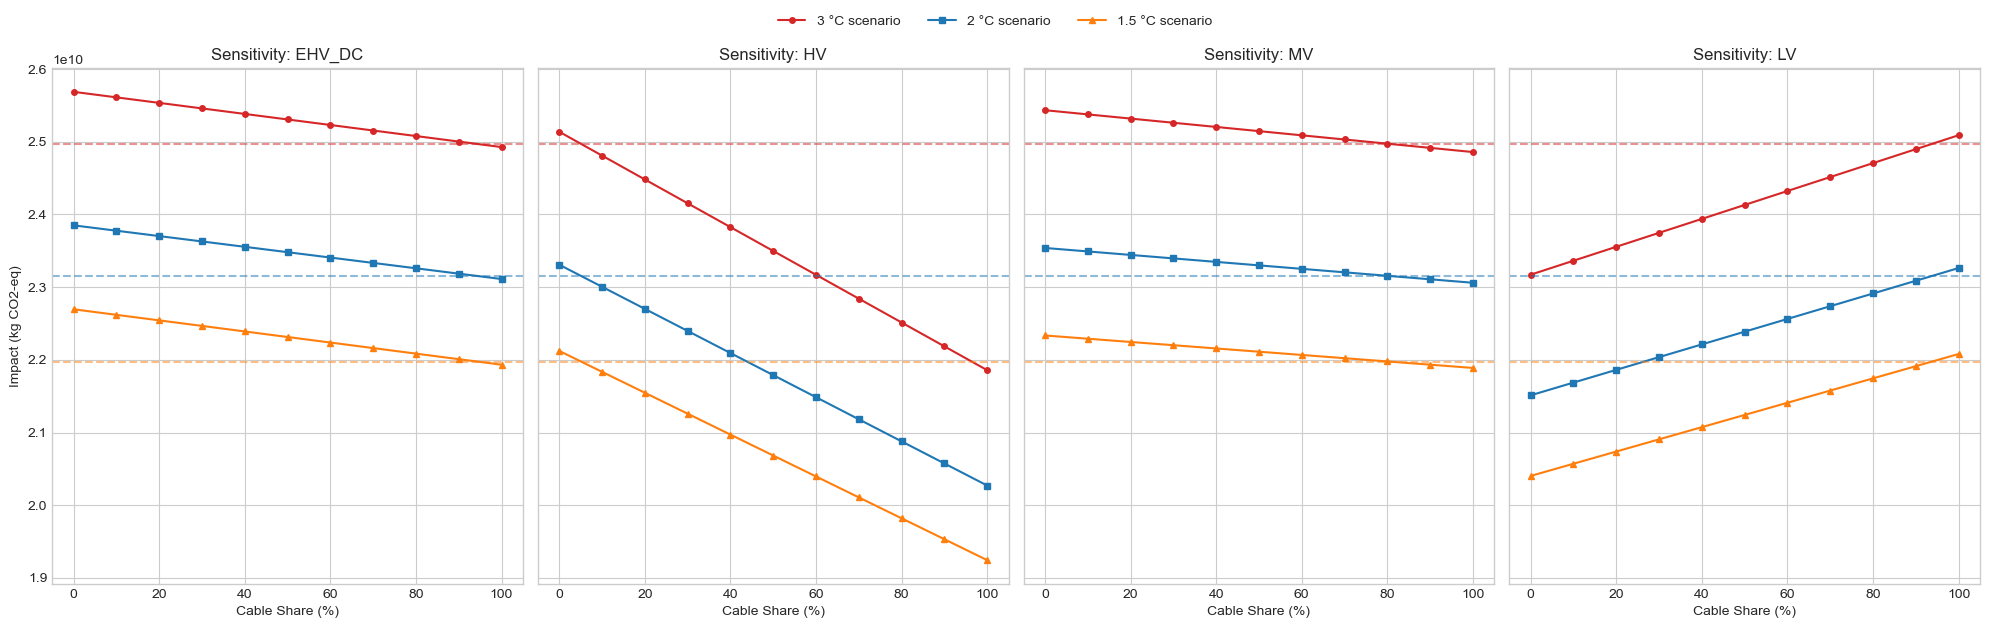

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

data_rows = []
for scenario_name, results_list in results_cable_share.items():
    for label, value in results_list:
        if label == "Baseline":
            # Tag baseline as applicable to all levels for plotting reference
            data_rows.append({
                'Scenario': scenario_name,
                'Level': 'Baseline',
                'Share': None,
                'Value': value
            })
        else:
            # New parsing: "MV_50pct" -> Level: "MV", Share: 50
            parts = label.split('_')
            level = parts[0] if len(parts) == 2 else f"{parts[0]}_{parts[1]}" # Handles EHV_DC
            share = int(parts[-1].replace('pct', ''))
            
            data_rows.append({
                'Scenario': scenario_name,
                'Level': level,
                'Share': share,
                'Value': value
            })

df_cable = pd.DataFrame(data_rows)

# Define styling per scenario (consistent with your previous plot)
scenarios_style = {
    'Base': {'name': '3 °C scenario', 'color': '#d62728', 'marker': 'o'},
    'PkBudg1000': {'name': '2 °C scenario', 'color': '#1f77b4', 'marker': 's'},
    'PkBudg650': {'name': '1.5 °C scenario', 'color': '#ff7f0e', 'marker': '^'}
}

# Get the list of unique voltage levels (excluding 'Baseline')
levels = [l for l in df_cable['Level'].unique() if l != 'Baseline']

# Create subplots: 1 row, 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

for i, level in enumerate(levels):
    ax = axes[i]
    
    for sc, style in scenarios_style.items():
        # Filter variation data for this specific level and scenario
        subset = df_cable[(df_cable['Scenario'] == sc) & (df_cable['Level'] == level)].sort_values('Share')
        
        # Filter baseline for this scenario
        baseline_val = df_cable[(df_cable['Scenario'] == sc) & (df_cable['Level'] == 'Baseline')]['Value'].values[0]
        
        # Plot sensitivity line
        ax.plot(subset['Share'], subset['Value'], 
                 label=f"{style['name']}", 
                 color=style['color'], 
                 marker=style['marker'], 
                 markersize=4, 
                 linewidth=1.5)
        
        # Plot baseline reference line
        ax.axhline(y=baseline_val, 
                    color=style['color'], 
                    linestyle='--', 
                    alpha=0.5)

    ax.set_title(f"Sensitivity: {level}")
    ax.set_xlabel('Cable Share (%)')
    if i == 0:
        ax.set_ylabel('Impact (kg CO2-eq)')

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

plt.tight_layout()
plt.savefig("figs/sensitivity_cable_share_split.svg", format="svg", bbox_inches="tight")
plt.show()

## Monte Carlo results

Obtained from Activity Browser

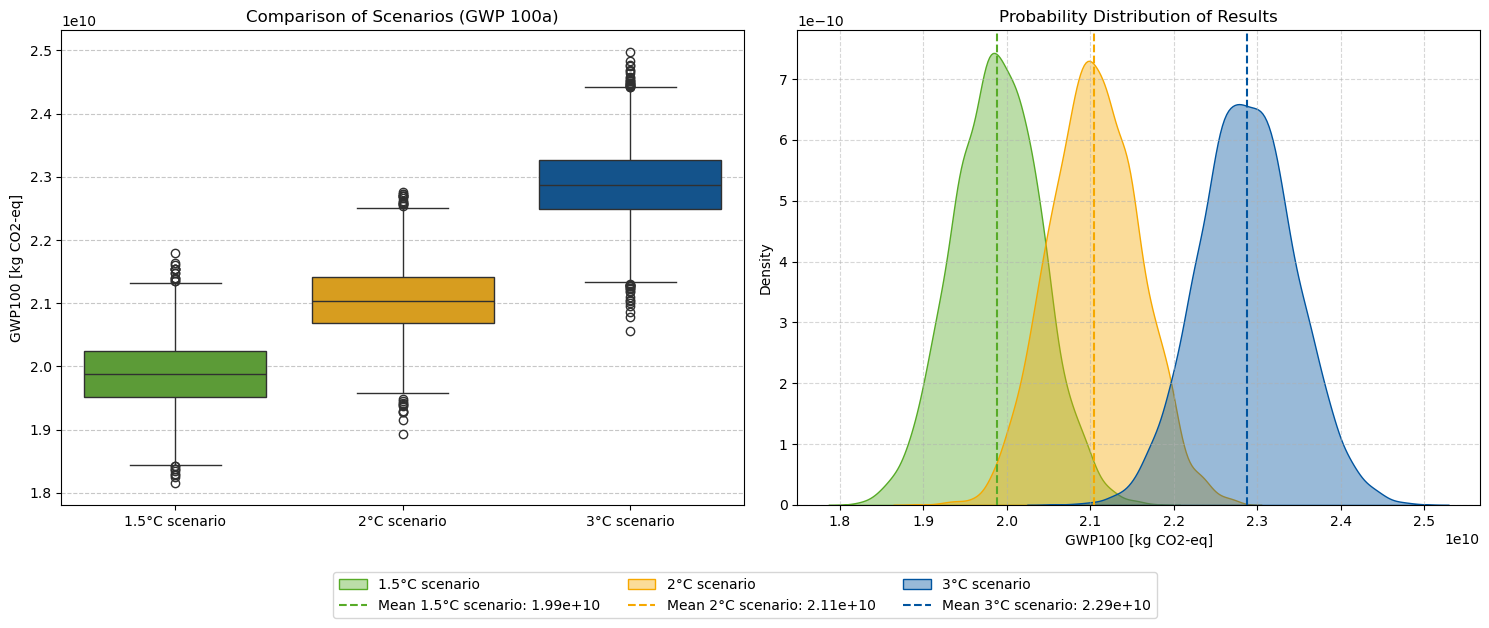

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
# Note: Use pd.read_excel if loading the original .xlsx file
file_path = 'data/uncertainty_Monte-Carlo-results_IPCC-2021-climate-change-GWP-100a-incl-H-and-bio-CO2.xlsx'
df = pd.read_excel(file_path, index_col=0)

# 2. Clean up and Rename Scenarios
# First, extract the short names from the long strings
df.columns = [c.split('|')[0].strip() for c in df.columns]

# Map the old names to the new scenario names
name_map = {
    'PkBudg650': '1.5°C scenario',
    'PkBudg1000': '2°C scenario',
    'NPi': '3°C scenario'
}
df = df.rename(columns=name_map)

# Update color_dict with the NEW names
color_dict = {
    '1.5°C scenario': '#57AB27',   
    '2°C scenario': '#F6A800', 
    '3°C scenario': '#00549F'
}

# 3. Create the plots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot for side-by-side comparison
sns.boxplot(data=df, ax=ax[0], palette=color_dict)
ax[0].set_title('Comparison of Scenarios (GWP 100a)')
ax[0].set_ylabel('GWP100 [kg CO2-eq]')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# KDE Plot for distribution shapes
for col in df.columns:
    color = color_dict[col]
    mean_val = df[col].mean()
    sns.kdeplot(df[col], label=f'{col}', fill=True, ax=ax[1], color=color, alpha=0.4)
    # Using ax[1].axvline instead of plt.axvline for better control in subplots
    ax[1].axvline(x=mean_val, color=color, linestyle='--', linewidth=1.5, 
                label=f'Mean {col}: {mean_val:.2e}')

ax[1].set_title('Probability Distribution of Results')
ax[1].set_xlabel('GWP100 [kg CO2-eq]')
ax[1].set_ylabel('Density')
ax[1].grid(axis='both', linestyle='--', alpha=0.5)

# 4. Extract handles and labels from the KDE axis for a shared legend
handles, labels = ax[1].get_legend_handles_labels()

# 5. Place the legend at the bottom of the figure
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# 6. Adjust layout to make room for the legend
plt.tight_layout()
fig.subplots_adjust(bottom=0.15) 

fig.savefig("figs/uncertainty.svg", format="svg", bbox_inches="tight")

plt.show()

### GSA Results

In [30]:
import pandas as pd
import re

# Define filenames and scenario names
gsa_files = {
    '1.5°C scenario': 'data/gsa_output_uncertainty_5000_PkBudg650_IPCC-2021-climate-change-GWP-100a-incl-H-and-bio-CO2xlsx.xlsx',
    '2°C scenario': 'data/gsa_output_uncertainty_5000_PkBudg1000_IPCC-2021-climate-change-GWP-100a-incl-H-and-bio-CO2xlsx.xlsx',
    '3°C scenario': 'data/gsa_output_uncertainty_5000_NPi_IPCC-2021-climate-change-GWP-100a-incl-H-and-bio-CO2xlsx.xlsx'
}

def clean_lca_name(name):
    """
    Cleans technical exchange names for readability.
    Example: 'T: FROM aggmarket for steel TO agggrid_NPi_2037' 
    becomes 'market for steel → Grid Expansion'
    """
    # Remove technical prefixes/suffixes
    name = name.replace('T:  FROM ', '').replace('agg', '').replace(' [GLO]', '').replace('()', '')
    
    parts = name.split(' TO ')
    if len(parts) == 2:
        src = parts[0].strip()
        dest = parts[1].strip()
        # Simplify destination if it contains specific grid scenario tags
        dest = re.sub(r'grid_.*_\d{4}', 'Grid Expansion', dest)
        return f"{src} → {dest}"
    return name.strip()

# 2. Process the data
scenario_results = []

for scenario, file_path in gsa_files.items():
    # Load and clean
    df = pd.read_excel(file_path, index_col=0)
    df['Exchange'] = df['GSA name'].apply(clean_lca_name)
    
    # Sort and drop duplicates (to ensure unique exchange/delta pairs)
    unique_df = df[['Exchange', 'delta']].drop_duplicates().sort_values('delta', ascending=False)
    
    # Prepare top 25 for the final table
    top25 = unique_df.head(25).copy()
    top25['Rank'] = range(1, len(top25) + 1)
    top25['Scenario'] = scenario
    scenario_results.append(top25)

# 3. Create the side-by-side comparison table
all_tops = pd.concat(scenario_results)
pivot_list = []

for scenario in gsa_files.keys():
    # Extract columns for this scenario and set Rank as index
    s_df = all_tops[all_tops['Scenario'] == scenario][['Rank', 'Exchange', 'delta']].copy()
    s_df.columns = ['Rank', f'{scenario} Exchange', f'{scenario} $\delta$']
    pivot_list.append(s_df.set_index('Rank'))

# Concatenate horizontally and round results
final_table = pd.concat(pivot_list, axis=1).round(4)
final_table.to_excel('data/gsa_top25_comparison_table.xlsx')

final_table

,1.5°C scenario Exchange,1.5°C scenario $\delta$,2°C scenario Exchange,2°C scenario $\delta$,3°C scenario Exchange,3°C scenario $\delta$
Rank,,,,,,
1,"market for aluminium, wrought alloy → Overhead...",0.0543,"Land cable, vpe insulated, aluminium, 0.4kV → ...",0.0557,"market for steel, unalloyed → Overhead line, 4...",0.0614
2,"market for aluminium, wrought alloy → Overhead...",0.0526,"Overhead line, 150kV → Grid Expansion",0.0554,"Land cable, oil insulated, copper, HVDC → Grid...",0.0568
3,"market for steel, unalloyed → Overhead line, 1...",0.0526,"market for steel, unalloyed → Overhead line, 4...",0.0552,"market for aluminium, wrought alloy → Land cab...",0.0567
4,"market for aluminium, wrought alloy → Overhead...",0.0504,"Land cable, vpe insulated, aluminium, 0.4kV → ...",0.0544,"market for aluminium, wrought alloy → Overhead...",0.0555
5,"Overhead line, 150kV → Grid Expansion",0.0504,"Land cable, vpe insulated, aluminium, 10kV → G...",0.0536,"market for steel, unalloyed → Overhead line, 1...",0.0546
6,"market for copper, cathode → Land cable, epr i...",0.0499,"Overhead line, 150kV → Grid Expansion",0.0536,"Land cable, vpe insulated, aluminium, 0.4kV → ...",0.0539
7,"market for steel, unalloyed → Overhead line, 4...",0.0499,"market for aluminium, wrought alloy → Land cab...",0.0535,"market for aluminium, wrought alloy → Overhead...",0.0520
8,"Land cable, oil insulated, copper, HVDC → Grid...",0.0499,"Overhead line, 400kV → Grid Expansion",0.0534,"Land cable, epr insulated, copper, 11kV → Grid...",0.0519
9,"Land cable, vpe insulated, aluminium, 10kV → G...",0.0488,"Land cable, vpe insulated, aluminium, 0.4kV → ...",0.0521,"Overhead line, 400kV → Grid Expansion",0.0510
